Training a BDT to predict $\delta C_9$ on an event-by-event basis

Import Libraries

In [25]:

import numpy as np

from sklearn.ensemble import HistGradientBoostingClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt

from library.plotting import setup_high_quality_mpl_params, plot_likelihood_over_bins, plot_prediction_linearity
from library.datasets import Aggregated_Signal_Binned_Dataset
from library.util import bootstrap_over_bins

ImportError: cannot import name 'plot_prediction_linearity' from 'library.plotting' (c:\Users\tetha\Desktop\btokstll\logic\scripts\library\plotting.py)

Setup / Deactivate Fancy Plotting

In [ ]:
# setup_high_quality_mpl_params()
# mpl.rcParams.update(mpl.rcParamsDefault)

Define Helper Functions

In [ ]:
def predict_set_likelihood(x, clf):
    """
    x : ndarray of events
    clf : sklearn classifier 
    """
    pred_prob = clf.predict_proba(x)
    pred = np.sum(np.log(pred_prob), axis=0)
    return pred


def predict_likelihood_over_bins(x, y, clf):
    """
    x : ndarray of events
    y : ndarray of bins
    clf : sklearn classifier
    """
    bins = np.unique(y)
    preds = []
    for bin in bins:
        x_bin = x[y==bin]
        pred = predict_set_likelihood(x_bin, clf)
        preds.append(np.expand_dims(pred, axis=0))
    preds = np.concatenate(preds, axis=0)
    assert preds.shape == (len(bins), len(bins))
    return preds


def predict_likelihood_over_bootstrapped_trials(x, y, n_trials, n_events, clf):
    """
    x : ndarray of events
    y : ndarray of bins
    n_trials : number of bootstrapped sample sets
    n_events : number of events to bootstrap per sample set
    """
    pred_bins_over_trials = []
    for _ in range(n_trials):
        boot_x, boot_y = bootstrap_over_bins(x, y, n_events)
        preds = predict_likelihood_over_bins(boot_x, boot_y, clf)
        pred_bins = np.argmax(preds, axis=1)
        pred_bins_over_trials.append(np.expand_dims(pred_bins, axis=0))
    pred_bins_over_trials = np.concatenate(pred_bins_over_trials)
    return pred_bins_over_trials


Load Data

In [5]:
level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

train_dataset = Aggregated_Signal_Binned_Dataset(level=level, split="train", raw_trials=range(1,11), save_dir=save_dir)
train_dataset.generate(raw_signal_dir)
train_dataset.load()

eval_dataset = Aggregated_Signal_Binned_Dataset(level=level, split="eval", raw_trials=range(21,23), save_dir=save_dir)
eval_dataset.generate(raw_signal_dir)
eval_dataset.load()

np.testing.assert_equal(train_dataset.bin_values, eval_dataset.bin_values)

train_x = train_dataset.feat.numpy()
train_y = train_dataset.labels.numpy()

eval_x = eval_dataset.feat.numpy()
eval_y = eval_dataset.labels.numpy()

Observe Class Balance

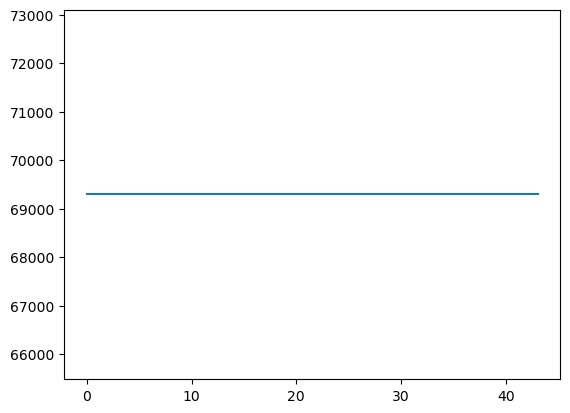

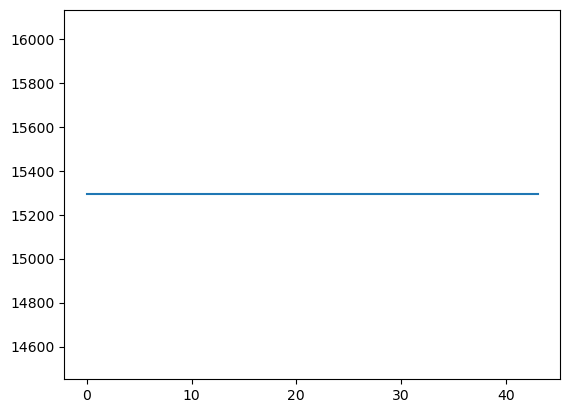

In [6]:
# Training data
bins, counts = np.unique(train_y, return_counts=True)
plt.plot(counts)
plt.show()

# Evaluation data
bins, counts = np.unique(eval_y, return_counts=True)
plt.plot(counts)
plt.show()

Fit the BDT

In [7]:
clf = HistGradientBoostingClassifier(max_iter=100, verbose=5).fit(train_x, train_y)

Binning 0.088 GB of training data: 0.104 s
Binning 0.010 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/100] 44 trees, 1364 leaves (31 on avg), max depth = 16, train loss: 3.78290, val loss: 3.78335, in 2.196s
[2/100] 44 trees, 1364 leaves (31 on avg), max depth = 21, train loss: 3.78181, val loss: 3.78270, in 1.881s
[3/100] 44 trees, 1364 leaves (31 on avg), max depth = 18, train loss: 3.78088, val loss: 3.78217, in 1.726s
[4/100] 44 trees, 1364 leaves (31 on avg), max depth = 16, train loss: 3.78004, val loss: 3.78174, in 1.662s
[5/100] 44 trees, 1364 leaves (31 on avg), max depth = 18, train loss: 3.77930, val loss: 3.78141, in 1.675s
[6/100] 44 trees, 1364 leaves (31 on avg), max depth = 19, train loss: 3.77861, val loss: 3.78114, in 1.641s
[7/100] 44 trees, 1364 leaves (31 on avg), max depth = 16, train loss: 3.77797, val loss: 3.78089, in 1.686s
[8/100] 44 trees, 1364 leaves (31 on avg), max depth = 19, train loss: 3.77740, val loss: 3.78072, in 1.618s
[9/100]

Evaluate Model Performance

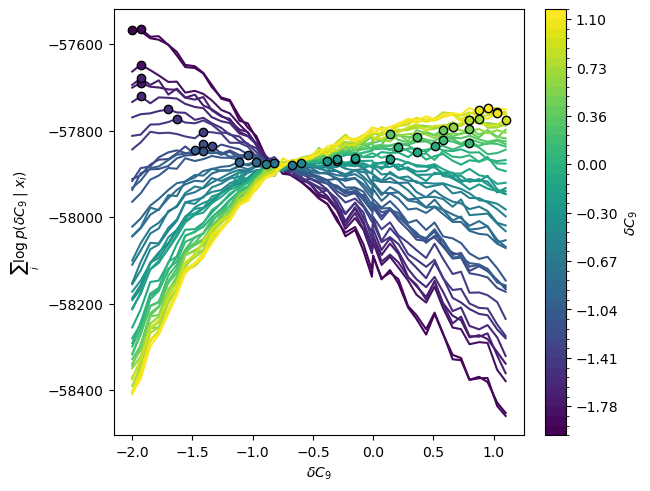

In [10]:
# On all data
preds = predict_likelihood_over_bins(eval_x, eval_y, clf)
plot_likelihood_over_bins(preds, eval_dataset.bin_values)

In [44]:
# On bootstrapped data
boot_x, boot_y = bootstrap_over_bins(eval_x, eval_y, 24000)
preds = predict_likelihood_over_bins(boot_x, boot_y, clf)

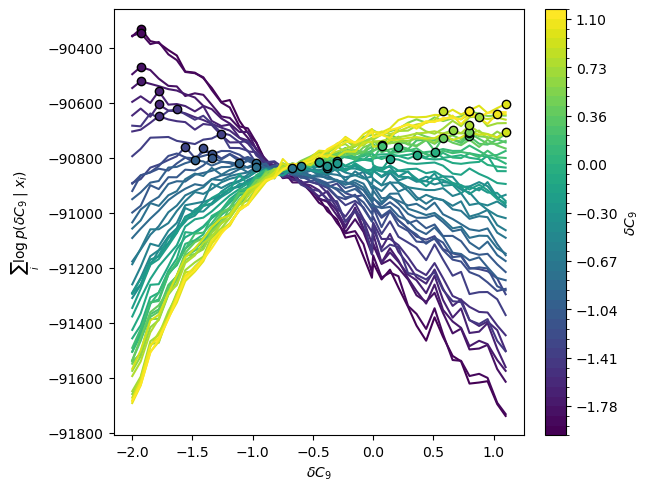

In [45]:
plot_likelihood_over_bins(preds, eval_dataset.bin_values)

In [13]:
# Over multiple bootstrapped trials

pred_bins_over_trials = predict_likelihood_over_bootstrapped_trials(eval_x, eval_y, 10, 24_000, clf)

pred_values_over_trials = eval_dataset.bin_values[pred_bins_over_trials]
avg_pred_values_over_trials = np.mean(pred_values_over_trials, axis=0)
stdev_pred_values_over_trials = np.std(pred_values_over_trials, axis=0)

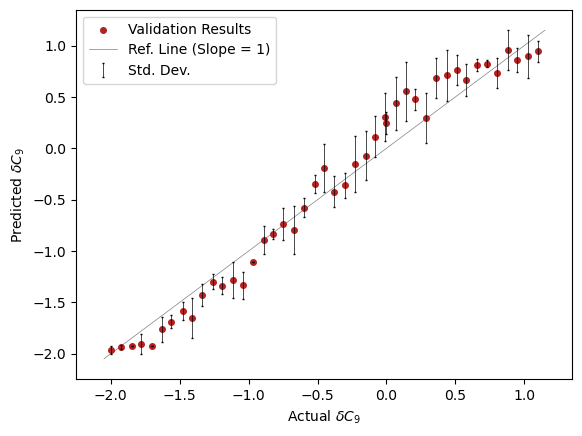

In [14]:
plot_prediction_linearity(
    eval_dataset.bin_values, 
    avg_pred_values_over_trials, 
    stdev_pred_values_over_trials, 
    ref_line_buffer=0.05, 
    xlim=(-2.25, 1.35), 
    ylim=(-2.25, 1.35), 
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)